# 0.0 Setup

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


✅ Dados carregados para análise bivariada
   Shape: (150000, 13)


# 1.0 Carregar dados


In [3]:
df_raw = pd.read_csv('../data/raw_data/df_raw_raw.csv')
target_col = 'inadipl_90dias_ult2anos'

print("✅ Dados carregados para análise bivariada")
print(f"   Shape: {df_raw_raw.shape}")

✅ Dados carregados para análise bivariada
   Shape: (150000, 13)


# 2.0 EDA Avançado

### 2.1 Análise de cada feature vs target

📊 ANÁLISE BIVARIADA: FEATURES vs TARGET

🔍 Analisando: id
--------------------------------------------------------------------------------
                                 mean   median           std
inadipl_90dias_ult2anos                                     
False                    74968.042429  74982.5  43297.906332
True                     75453.643427  75283.0  43349.986634

📈 Mann-Whitney U test:
   p-value: 0.2780
   ❌ Sem diferença significativa


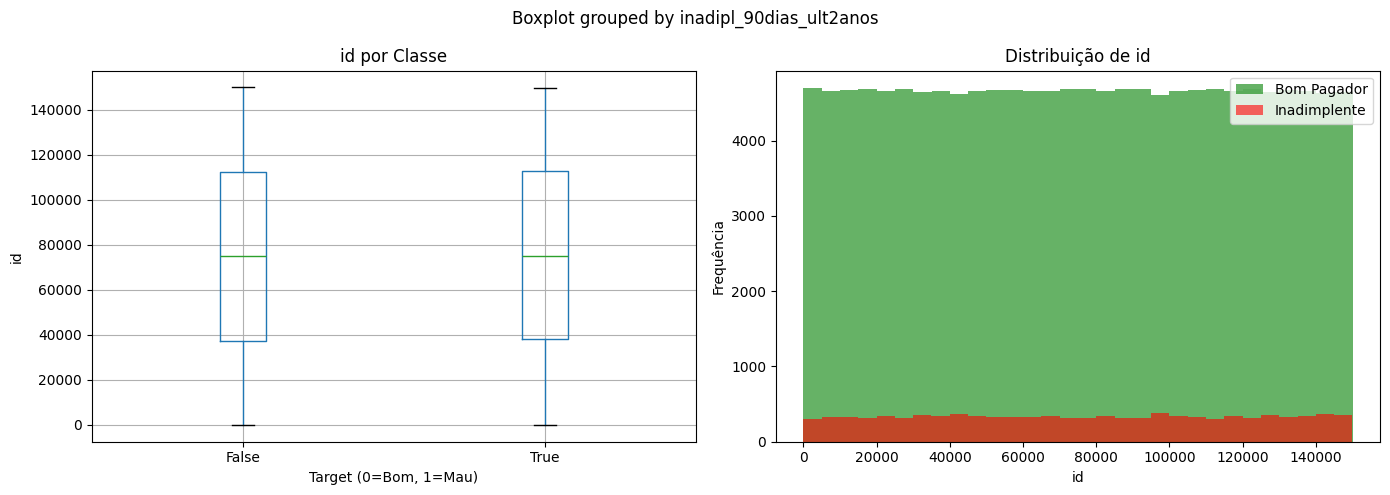


🔍 Analisando: utilizacao_credito
--------------------------------------------------------------------------------
                             mean  median         std
inadipl_90dias_ult2anos                              
False                    6.173795  0.1336  256.228822
True                     4.368152  0.8390  131.848916

📈 Mann-Whitney U test:
   p-value: 0.0000
   ✅ Diferença estatisticamente significativa!


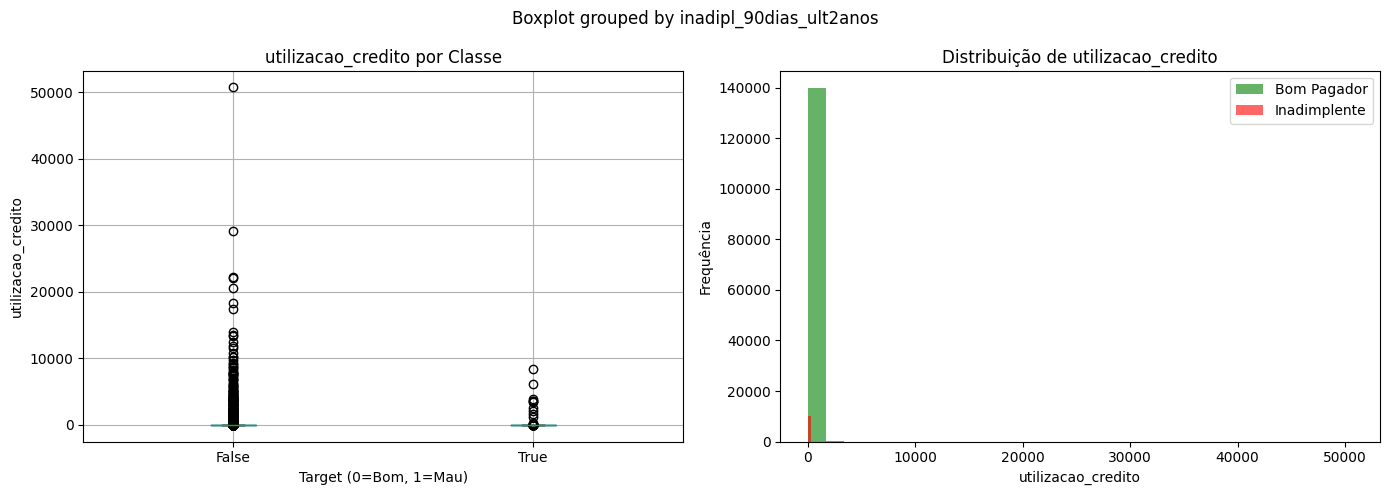


🔍 Analisando: idade
--------------------------------------------------------------------------------
                              mean  median        std
inadipl_90dias_ult2anos                              
False                    52.751375    52.0  14.791079
True                     45.926591    45.0  12.916289

📈 Mann-Whitney U test:
   p-value: 0.0000
   ✅ Diferença estatisticamente significativa!


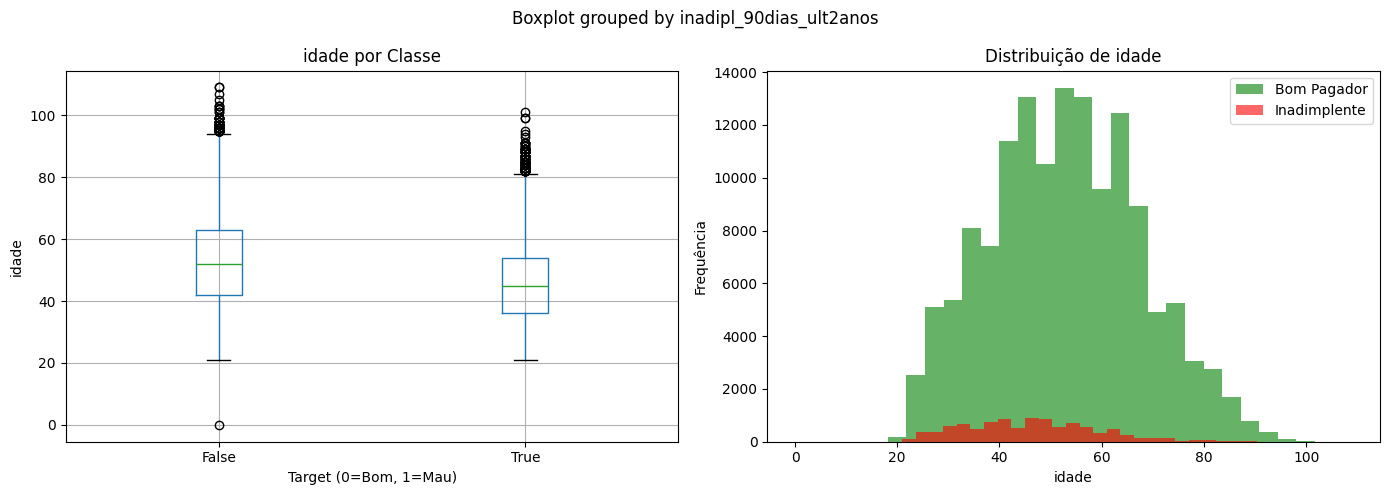


🔍 Analisando: atrasos_30dias
--------------------------------------------------------------------------------
                             mean  median        std
inadipl_90dias_ult2anos                             
False                    0.280109     0.0   2.946075
True                     2.388490     0.0  11.734510

📈 Mann-Whitney U test:
   p-value: 0.0000
   ✅ Diferença estatisticamente significativa!


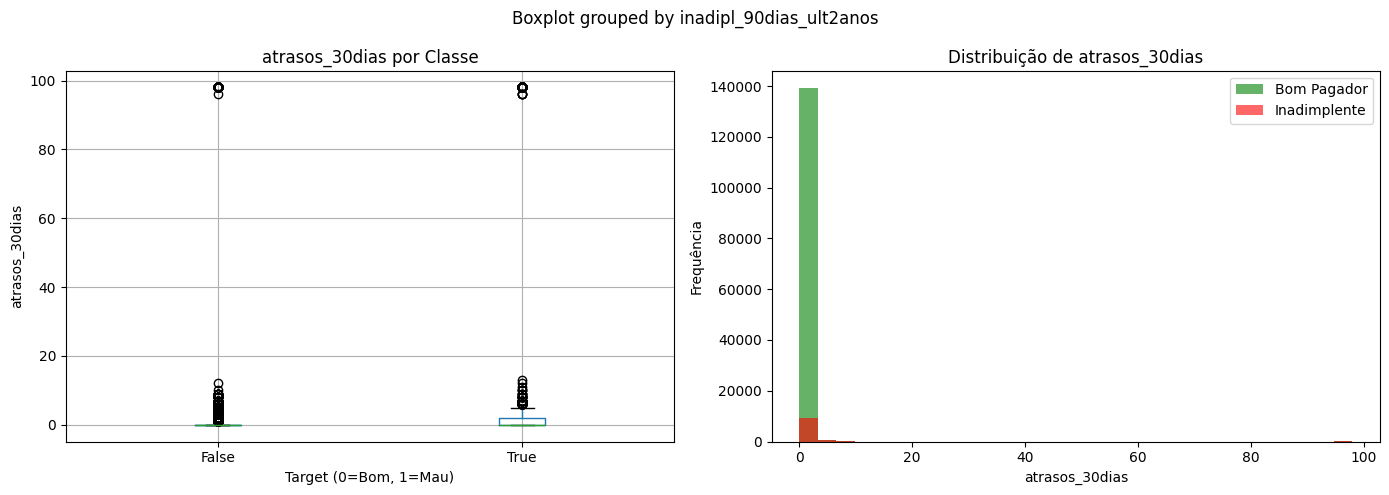


🔍 Analisando: divida_ratio
--------------------------------------------------------------------------------
                               mean   median          std
inadipl_90dias_ult2anos                                  
False                    357.197101  0.36270  2083.412087
True                     295.121067  0.42825  1238.360283

📈 Mann-Whitney U test:
   p-value: 0.0000
   ✅ Diferença estatisticamente significativa!


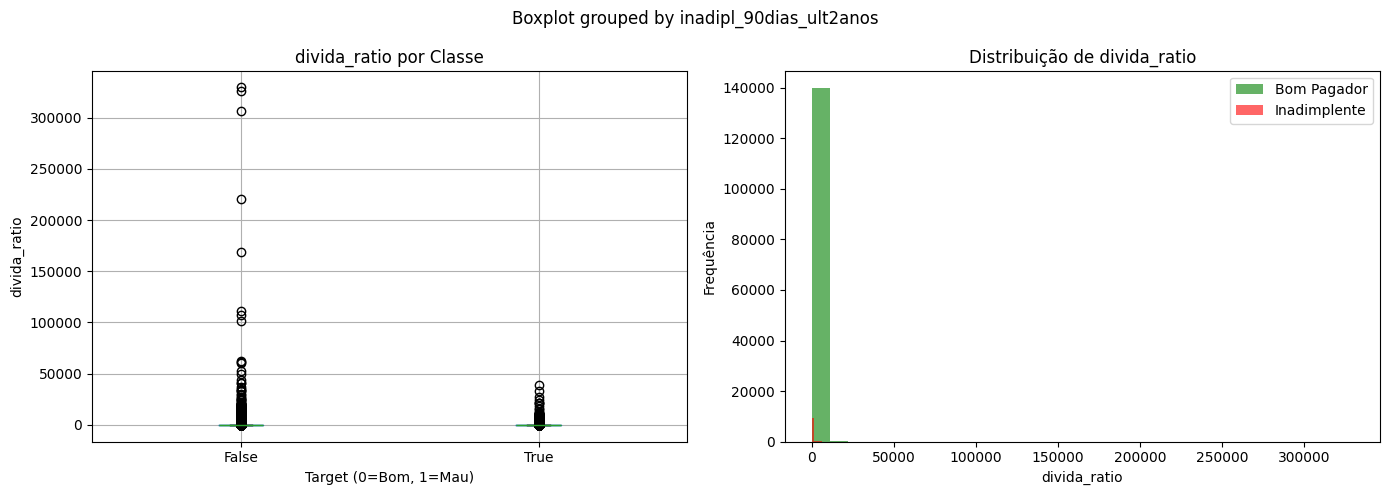

In [12]:
# Seleciona colunas numéricas, excluindo o target
numeric_cols = [col for col in df_raw.select_dtypes(include=[np.number]).columns if col != target_col]

print("=" * 80)
print("📊 ANÁLISE BIVARIADA: FEATURES vs TARGET")
print("=" * 80)

for col in numeric_cols[:5]:  # Primeiras 5 para exemplo
    print(f"\n🔍 Analisando: {col}")
    print("-" * 80)
    
    # Estatísticas por grupo
    stats_by_target = df_raw.groupby(target_col)[col].agg(['mean', 'median', 'std'])
    print(stats_by_target)
    
    # Teste estatístico (Mann-Whitney U)
    good = df_raw[df_raw[target_col] == 0][col].dropna()
    bad = df_raw[df_raw[target_col] == 1][col].dropna()
    
    statistic, pvalue = stats.mannwhitneyu(good, bad, alternative='two-sided')
    print(f"\n📈 Mann-Whitney U test:")
    print(f"   p-value: {pvalue:.4f}")
    if pvalue < 0.05:
        print(f"   ✅ Diferença estatisticamente significativa!")
    else:
        print(f"   ❌ Sem diferença significativa")
    
    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    df_raw.boxplot(column=col, by=target_col, ax=axes[0])
    axes[0].set_title(f'{col} por Classe')
    axes[0].set_xlabel('Target (0=Bom, 1=Mau)')
    axes[0].set_ylabel(col)
    
    # Histograma sobreposto
    axes[1].hist(good, bins=30, alpha=0.6, label='Bom Pagador', color='green')
    axes[1].hist(bad, bins=30, alpha=0.6, label='Inadimplente', color='red')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequência')
    axes[1].set_title(f'Distribuição de {col}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    print("=" * 80)


### 2.2 Análise de poder discriminatório (IV - Information Value)

📊 INFORMATION VALUE (IV) - PODER PREDITIVO
                      Feature        IV          Classificação
1          utilizacao_credito  1.114338          ⚡ Muito forte
9                 dependentes  0.483980                🌟 Forte
3              atrasos_30dias  0.471831                🌟 Forte
2                       idade  0.259158                ✅ Médio
5                renda_mensal  0.080386               ⚠️ Fraco
4                divida_ratio  0.073524               ⚠️ Fraco
6      linhas_credito_abertas  0.066892               ⚠️ Fraco
10      comprometimento_renda  0.032808               ⚠️ Fraco
8   emprestimos_imobiliarioss  0.012091  ❌ Sem poder preditivo
0                          id  0.001575  ❌ Sem poder preditivo
7              atrasos_90dias  0.000000  ❌ Sem poder preditivo


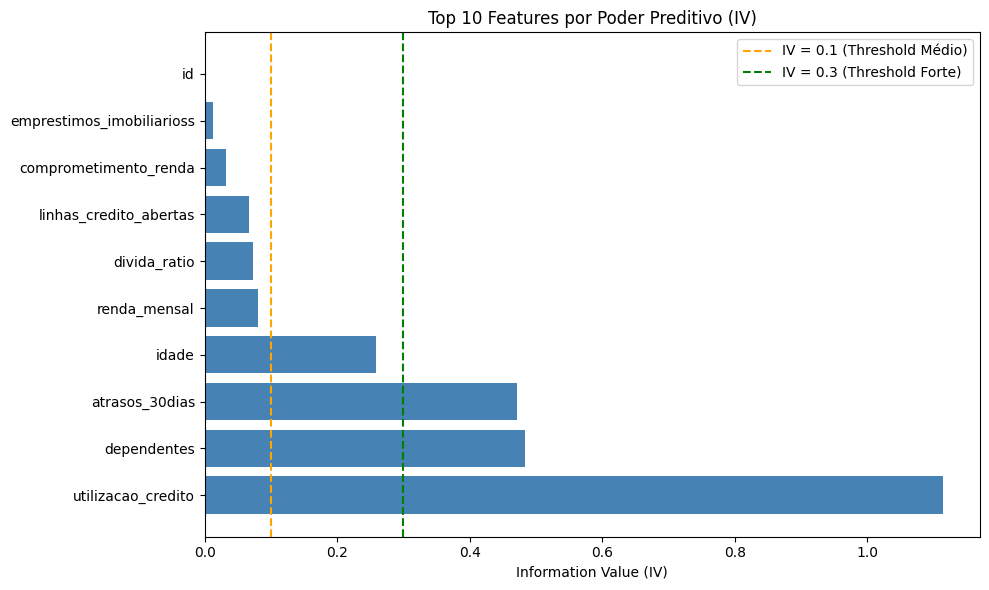

In [15]:
def calculate_iv(df, feature, target):
    """Calcula Information Value de uma feature"""
    df_iv = df[[feature, target]].dropna().copy()
    
    # Se a coluna tiver poucos valores únicos, usar cut em vez de qcut
    try:
        if df_iv[feature].nunique() < 10:
            df_iv['bins'] = pd.cut(df_iv[feature], bins=df_iv[feature].nunique())
        else:
            df_iv['bins'] = pd.qcut(df_iv[feature], q=10, duplicates='drop')
    except Exception:
        return 0
    
    # Calcular WOE e IV
    grouped = df_iv.groupby('bins')[target].agg(['sum', 'count'])
    grouped['good'] = grouped['count'] - grouped['sum']
    grouped['bad'] = grouped['sum']
    
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_pct'] = grouped['good'] / total_good
    grouped['bad_pct'] = grouped['bad'] / total_bad
    
    # Evitar divisão por zero
    grouped = grouped[(grouped['good_pct'] > 0) & (grouped['bad_pct'] > 0)]
    
    grouped['woe'] = np.log(grouped['good_pct'] / grouped['bad_pct'])
    grouped['iv'] = (grouped['good_pct'] - grouped['bad_pct']) * grouped['woe']
    
    iv = grouped['iv'].sum()
    return iv

# Calcular IV para todas as colunas numéricas
iv_scores = {}
for col in numeric_cols:
    iv_scores[col] = calculate_iv(df_raw, col, target_col)

# Criar DataFrame com classificação
iv_df = pd.DataFrame(list(iv_scores.items()), columns=['Feature', 'IV'])
iv_df['Classificação'] = pd.cut(
    iv_df['IV'],
    bins=[-np.inf, 0.02, 0.1, 0.3, 0.5, np.inf],
    labels=["❌ Sem poder preditivo", "⚠️ Fraco", "✅ Médio", "🌟 Forte", "⚡ Muito forte"]
)

# Ordenar por IV
iv_df = iv_df.sort_values('IV', ascending=False)

print("=" * 80)
print("📊 INFORMATION VALUE (IV) - PODER PREDITIVO")
print("=" * 80)
print(iv_df)

# Visualizar top features
top_iv = iv_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_iv['Feature'], top_iv['IV'], color='steelblue')
plt.xlabel('Information Value (IV)')
plt.title('Top 10 Features por Poder Preditivo (IV)')
plt.axvline(x=0.1, color='orange', linestyle='--', label='IV = 0.1 (Threshold Médio)')
plt.axvline(x=0.3, color='green', linestyle='--', label='IV = 0.3 (Threshold Forte)')
plt.legend()
plt.tight_layout()
plt.show()
